In [1]:
!pip install particles

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from particles import kalman

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# reading the German credit dataset
# path = '/content/drive/MyDrive/Group_Projects/SBM/Project_2/' #path Elsa
# path = '/content/drive/MyDrive/SBM/Project_2/' #path Romain
dataset = pd.read_csv("nile.csv")


2. We will use the first 80 measurements from 1871 to 1950 as our training dataset and the last
20 measurements from 1951 to 1970 as our testing dataset. Implement this split

In [4]:
# split dataset
trainset = dataset[:80]
testset = dataset[80:]
ytrain = np.array(trainset['flow'])

print("trainset size:", trainset.shape[0], "\n",
      "testset size:", testset.shape[0], "\n")

trainset size: 80 
 testset size: 20 



In [5]:
#plot trainset series

import datetime
dti = pd.date_range("1871", periods=len(trainset), freq="Y")
dti_tot = pd.date_range("1871", periods=len(dataset), freq="Y")

df = dti.to_frame(index=False)
df_tot = dti_tot.to_frame(index=False)

df['year'] = pd.DatetimeIndex(df[0]).year
df.drop(columns=[0], inplace=True)

df_tot['year'] = pd.DatetimeIndex(df_tot[0]).year
df_tot.drop(columns=[0], inplace=True)

dataset_timeseries =  pd.concat([dataset, df_tot], axis=1)
dataset_timeseries = dataset_timeseries[["year", "flow"]]

trainset_timeseries = pd.concat([trainset, df], axis=1)
trainset_timeseries = trainset_timeseries[["year", "flow"]]

In [6]:
trainset_timeseries.head()

,year,flow
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160


3. Plot the time series and observe the apparent changepoint near 1898. Speculate why this
might be the case.

We can see that the flow drops from 1100 to around 770 units from 1898 to 1899. This is probably due to the construction of the first dam across the Nile by the British in 1898.

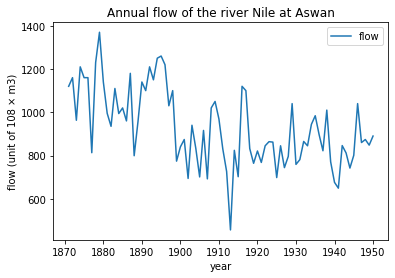

In [7]:
# plot train series 

trainset_timeseries.plot(x="year", y="flow")
plt.xlabel("year")
plt.ylabel("flow (unit of 108 × m3)")
plt.title("Annual flow of the river Nile at Aswan")
plt.show()


4. We will model the annual flow Xt and its measurement Yt

in year t+1871, for t = 0, 1, . . . , 99, using the following univariate linear Gaussian state space model

X0 ∼ N(1120, 1450),
Xt = Xt−1 + Ut

Ut ∼ N(0, σ2X), (1)

Yt = Xt + Vt

, Vt ∼ N(0, σ2
Y
).

Using the kalman module from the particles package, write a function that constructs the
state space model (1) for any choice of parameters θ = (σ
2
X, σ2
X). This function should take

σ
2
X and σ
2
Y
as arguments and output a MVLinearGauss object.

In [8]:
def construct_ssm(sigma_X, sigma_Y):
    #initial distribution
    mu0 = np.array([1120])
    cov0 = np.array([1450])
    # state transtion matrix
    F=np.array([1])
    Sigma_X = np.array([sigma_X])

    # observation transition matrix
    G=np.array([1])
    # observation covariance matrix
   
    Sigma_Y = np.array([sigma_Y])
    # create a state space model for target tracking
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=Sigma_X, covY = Sigma_Y, mu0=mu0, cov0=cov0)
    
    return ssm

# true data generating state space model
ssm = construct_ssm( sigma_X = 1, sigma_Y = 1)
T = 80
true_states, observations = ssm.simulate(T) # simulate data 

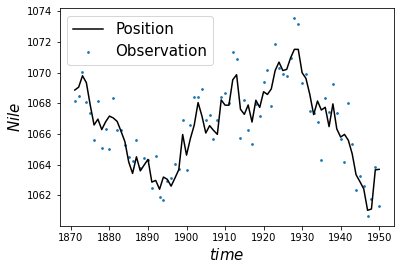

In [9]:
X= [x[0,0] for x in true_states]
Y = [y[0,0] for y in observations]
plt.figure()
plt.plot(trainset_timeseries['year'],X, color = "black")
plt.scatter(trainset_timeseries['year'], Y, s = 3)
plt.xlabel("$time$", fontsize = 15)
plt.ylabel("$Nile$", fontsize = 15)
plt.legend(["Position", "Observation"], fontsize = 15)

#trainset_timeseries

In [10]:
# define function to evaluate log-likelihood using Kalman filter
def loglikelihood(theta, data=ytrain):
    
    # get parameters
    sigma_X = theta[0]
    sigma_Y = theta[1]
    
    # construct state space model
    ssm = construct_ssm(sigma_X, sigma_Y)
    
    # run Kalman filter to evaluate log-likelihood
    kf = kalman.Kalman(ssm = ssm, data = data)
    kf.filter()
    return(np.sum(kf.logpyt))

Compute the maximum likelihood estimator

θb = arg max log p(y0, y1, . . . , y79|θ)

using the minimize function from the SciPy optimize subpackage. Initialize the optimization
routine at θ = (σ
2
X, σ2
Y
) = (1450, 15000) and use the Nelder–Mead algorithm by specifying the method parameter.

In [11]:
from scipy.optimize import minimize

def neg_loglikelihood(theta):
  return (-loglikelihood(theta))

theta0 = [1450, 15000]
theta_b = minimize(neg_loglikelihood, x0=theta0, method='Nelder-Mead')

# get max likelihood estimator
theta_b = theta_b.x
print(theta_b)

[ 1438.04517468 16003.77131545]


7. Using the kalman module from the particles package, perform Kalman filtering and Kalman
smoothing on the state space model (1) with the maximum likelihood estimator θb.

In [12]:
# ussing the maximum likelihood estimator
sigma_x = theta_b[0]
sigma_y = theta_b[1]

ssm = construct_ssm(sigma_x, sigma_y)

# we run the Kalman filter at the optimized parameter
kf = kalman.Kalman(ssm  = ssm, data = ytrain)
kf.filter() 
kf.smoother()

# position filtering means 
filtering_means = [filtering.mean[0] for filtering in kf.filt]
filtering_covs = [filtering.cov[0] for filtering in kf.filt]

# position smoothing means 
smoothing_means = [smoothing.mean[0] for smoothing in kf.smth]
smoothing_covs = [smoothing.cov[0] for smoothing in kf.smth]
# plot means

8. Plot the filtering mean E[Xt|θ, y b 0, y1, . . . , yt], the smoothing mean E[Xt|θ, y b 0, y1, . . . , y79] and

the measurement yt for t = 0, 1, . . . , 79. Comment on the differences between the filtering and smoothing means. Explain why the changepoint near 1898 is also reflected in these means.

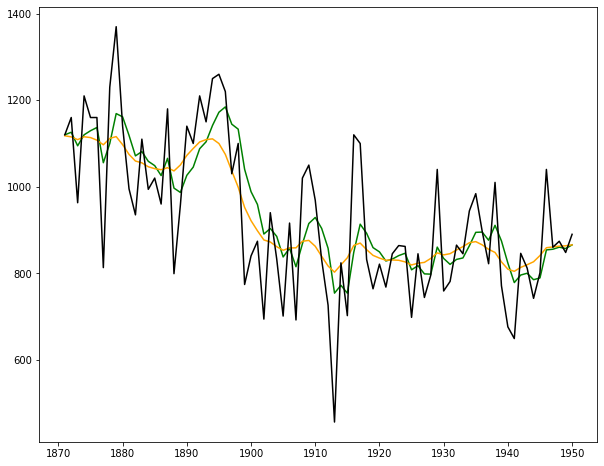

In [13]:
fig = plt.figure(figsize=(10, 8))
plt.plot(trainset_timeseries['year'],filtering_means, color = "green")
plt.plot(trainset_timeseries['year'],smoothing_means, color = "orange")
plt.plot(trainset_timeseries['year'],ytrain, color = "black")
plt.show()

As we could expect, the soothing curve is smoother than the filtering one. In fact, as the smoothing mean condition on more observation then the filtering one so going from one step to another change less the expected value than in filtering.

Futermore, As Y_t has a linear relation with X_t, the latent state, a changepoint in X_t implied the changepoint in Y_t. Is is than logically expected to see a changepoint around 1898 in X_t and thus in E[X_t ] 

9. Compare the filtering variance Var[Xt|θ, y b 0, y1, . . . , yt] and the smoothing variance Var[Xt|θ, y b 0, y1, . . . , y79] for t = 0, 1, . . . , 79. Explain these differences.

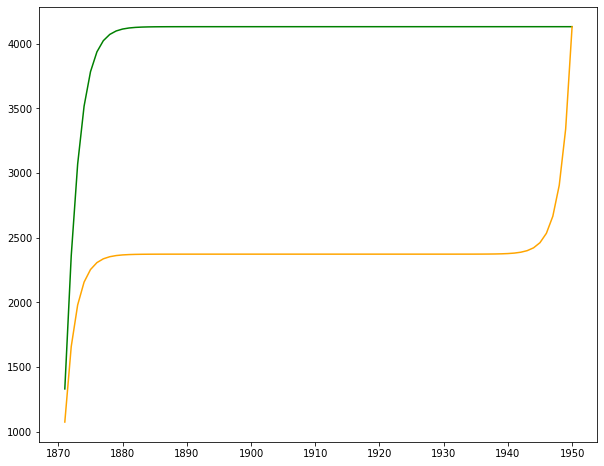

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.plot(trainset_timeseries['year'],filtering_covs, color = "green")
plt.plot(trainset_timeseries['year'],smoothing_covs, color = "orange")
plt.show()

We can clearly see that the filtering variance is higher than the smoothing one. As explain before, as the condition expectation of the smoothing take more past values than the filtering (for a given t), there is less variance in the change of value between a time t and t+1. 

10. Using the state space model (1) with the maximum likelihood estimator θb, compute the predictive mean E[Yt|θ, y b 0, y1, . . . , y79] and the predictive variance Var[Yt|θ, y b 0, y1, . . . , y79],for t = 80, . . . , 99, of the 20 measurements from 1951 to 1970.

In [15]:
# computing the predictive means and  variances
pred_means_latent = np.zeros(20)
pred_variances_latent = np.zeros(20)

pred_means_y = np.zeros(20)
pred_variances_y = np.zeros(20)

# Initialisation
pred_means_latent[0] = 1 * filtering_means[79]
pred_variances_latent[0] = (1**2) * filtering_covs[79] + sigma_x

pred_means_y[0] = pred_means_latent[0]
pred_variances_y[0] = pred_variances_latent[0] + sigma_y

for i in range(1, 20):   
      # step 1: get predictive mean & variance of LATENT state
    pred_means_latent[i] = 1 * pred_means_latent[i-1]
    pred_variances_latent[i] = (1**2) * pred_variances_latent[i-1] + sigma_x

    # step 2: get predictive mean & variance of OBSERVATION (y)
    pred_means_y[i] = pred_means_latent[i]
    pred_variances_y[i] = pred_variances_latent[i] + sigma_y

11. Using the predictive means and variances, compare the predictive distributions with the 20 measurements from 1951 to 1970 in our testing dataset.

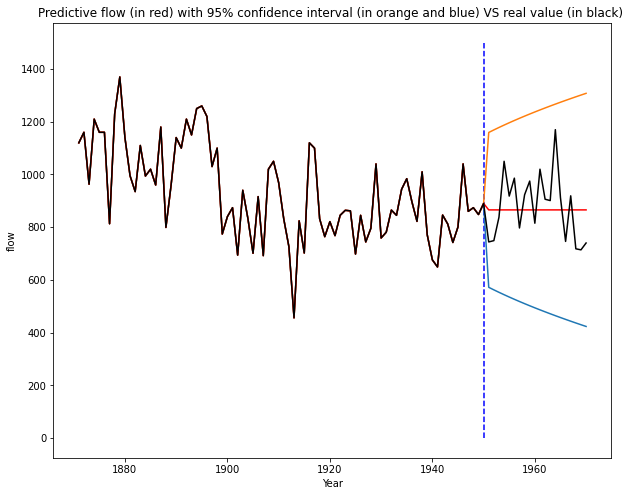

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(dataset_timeseries['year'], np.concatenate((ytrain, pred_means_y - 2*np.sqrt(pred_variances_y))))
ax.plot(dataset_timeseries['year'], np.concatenate((ytrain, pred_means_y + 2*np.sqrt(pred_variances_y))))
ax.plot(dataset_timeseries['year'], np.concatenate((ytrain, pred_means_y)), color ="red")
ax.plot(dataset_timeseries['year'], dataset_timeseries['flow'], color ="black")
ax.vlines([1950], 0, 1500, linestyles='dashed', colors='blue')

plt.title("Predictive flow (in red) with 95% confidence interval (in orange and blue) VS real value (in black) ")
plt.xlabel("Year")
plt.ylabel("flow")
plt.show()

# **2) Bass diffusion model for the number of youtube users**

1. Read the youtube dataset using the read_csv function from the pandas package.

In [61]:
df = pd.read_csv('youtube.csv')
df.head(2)

,Year,Monthly active users
0,2005,1946322
1,2006,19878248


In [48]:
data_values = df["Monthly active users"].values
data_values

array([   1946322,   19878248,  143932250,  294493950,  413611440,
        480551990,  642669824,  844638200, 1065223075, 1249451725,
       1328133360, 1399053600, 1495657000, 1900000000])

2. Plot the time series and comment on its behaviour.

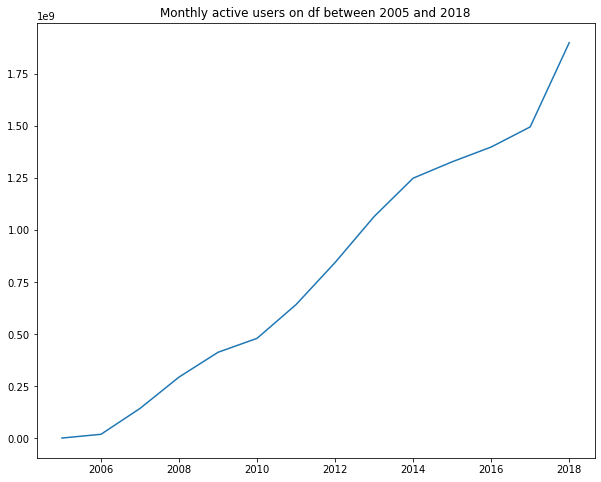

In [49]:
fig = plt.figure(figsize=(10,8))
plt.plot(df['Year'],df['Monthly active users'])
plt.title("Monthly active users on df between 2005 and 2018")
plt.show()

The global behaviour of this time series is clearly a linear growth on this period.

3. We will model the number of users on df Xt and its measurement Yt in year t + 2005, for t = 0, 1, . . . , 13, using the following stochastic Bass state space model


*  X0 ∼ Binomial(N, β0),
*  Xt ∼ ShiftedBinomial(N − Xt−1, α + βXt−1/N, Xt−1), (2)
*  Yt ∼ TruncNormal(Xt, σ2),

with unknown parameters θ = (β0, α, β, σ). We will set N as the world population size of 7.7 billion. Using the particles package, define the Bass state space model (2) as a class bass with methods PX0, PX and PY. [Hint: use the ShiftedBinomial object and refer to the documentation page  https:/particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/distributions.html.]

In [55]:
import scipy.stats as stats
import particles
from particles import distributions as dists  
from particles import state_space_models as ssm  
from particles.collectors import Moments 
from particles import mcmc

class ShiftedBinomial(dists.DiscreteDist):
    """Shifted Binomial(n,p) distribution."""
    def __init__(self, n=1, p=0.5, loc=0):
        self.n = n
        self.p = p
        self.loc = loc

    def rvs(self, size=None):
        return stats.binom.rvs(self.n, self.p, loc = self.loc, size = size)

    def logpdf(self, x):
        return stats.binom.logpmf(x, self.n, self.p, self.loc)

    def ppf(self, u):
        return stats.binom.ppf(u, self.n, self.p, self.loc)

    
class Bass(ssm.StateSpaceModel): # subclass StateSpaceModel
    def PX0(self):
        return dists.Binomial(N,self.beta0)
    
    def PX(self, t, xt_1):
        return ShiftedBinomial(N-xt_1,self.alpha+self.beta*xt_1/N,xt_1)
    
    def PY(self,t,xp,x): 
        """Observation density"""
        return dists.TruncNormal(mu=x, sigma=self.sigma, a=0, b=10**12)


4. We adopt the following independent prior distribution p(θ) for the parameters
β0, α ∼ Beta(1, 100), β ∼ Beta(2, 20), σ ∼ TruncNormal(1.5 × 108,(0.3 × 108)). 
(3)

Using the particles package, define the prior distribution in (3). Plot the prior probability density function of each parameter and comment on the appropriateness of this prior distribution. [Hint: use the method logpdf that distribution objects have and use the interpretation of the parameters in (2).]

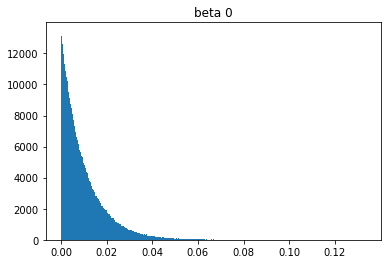

In [71]:
# distributions
Xt = 1500000000
sig = 300000000

beta_0 = dists.Beta(1,100)
alpha = dists.Beta(1,100)
beta = dists.Beta(2,20)
sigma = dists.TruncNormal(Xt, sig, a=0, b = np.inf)


# beta0 distribution
x = beta_0.rvs(size=1000000) 
plt.hist(x, bins=1000)
plt.title("beta 0")
plt.show()

beta0 is modeling the uncertainty of people on the platform from x0

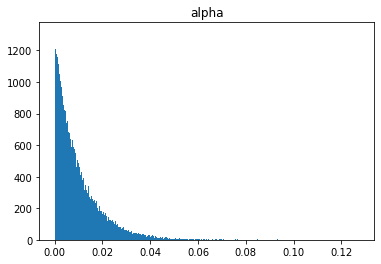

In [65]:
x = alpha.rvs(size=100000) 
plt.hist(x, bins=1000)
plt.title("alpha")
plt.show()

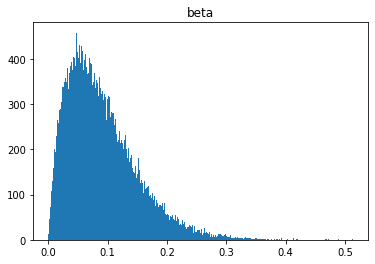

In [66]:
x = beta.rvs(size=100000) 
plt.title("beta")
plt.hist(x, bins=1000)
plt.show()

alpha and beta show the number of people who arent eyt on the platform and will adopt with a probability $\alpha + \beta X_{t-1}$

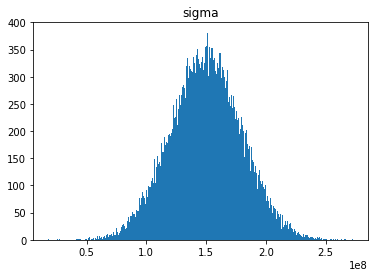

In [67]:
x = sigma.rvs(size=100000) 
plt.hist(x, bins=1000)
plt.title("sigma")
plt.show()

Std/variability of the measurement of $Y_t$

5. Run a particle marginal Metropolis–Hastings with 20 particles for 5000 iterations to sample from the posterior distribution p(θ|y0, y1. . . , y13). [Warning: this may take a minute on your machine.] Report the resulting acceptance rate. Use diagnostic plots to examine the mixing properties of the Markov chain and an appropriate choice of burn-in.





In [72]:
# define marginal prior distributions
N = 7700000000
prior_param = {'beta0':dists.Beta(1,100),
              'beta':dists.Beta(2,20),
              'alpha':dists.Beta(1,100), 
              'sigma':dists.TruncNormal(Xt, sig, a=0, b=np.inf)}

prior = dists.StructDist(prior_param) # constructs our joint prior distribution 

In [26]:
# number of MCMC iterations
nb_iter = 5000    

pmmh = mcmc.PMMH(ssm_cls = Bass, prior = prior, data = df["Monthly active users"].values, Nx = 20, niter = nb_iter)

# actual computation 
pmmh.run() 

**Comments**

The prior distribution is appropriate if the sampled parameters seem plausible when plugged inside the model's equations.

* beta represent the proporton of population that arrives on the platefrom from other previous users. Here, Beta will be around 0.5 which seems reasonable.

* alpha represents the proportion of new active users which are not linked to the previous users. It seems then reasonable that beta_0 and alpha have the same distribution since both represent new users, not linked to previous ones (beta_0 represent the first new users). 

* sigma, is the variance,has a value around 1.5*10^8 = 150 000 000 and so a standard deviation of 12 000 users. This value of a change of 12 000 users per months as actives users of df make sense. 

In [27]:
#acceptance rate
print(pmmh.acc_rate)

0.3190638127625525


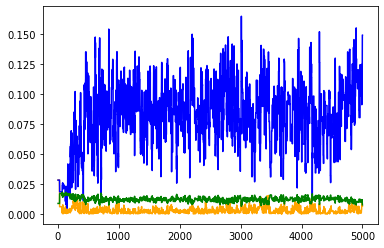

In [28]:
# convergence diagnostics: trace plots
iteration = np.arange(1, nb_iter+1)
plt.plot(iteration, pmmh.chain.theta['beta0'], color='orange')
plt.plot(iteration, pmmh.chain.theta['beta'],color='blue')
plt.plot(iteration, pmmh.chain.theta['alpha'], color='green')
plt.show()

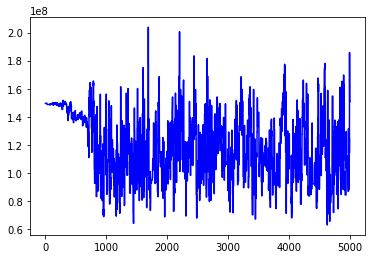

In [30]:
iteration = np.arange(1, nb_iter+1)
plt.plot(iteration, pmmh.chain.theta['sigma'], color="blue")
plt.show()

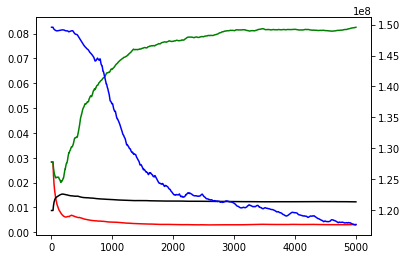

In [74]:
# convergence diagnostics: sample averages over iterations
iteration = np.arange(1, nb_iter+1)
fig, ax1 = plt.subplots()
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['beta0']) / iteration, color='red')
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['beta']) / iteration, color='green')
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['alpha']) / iteration, color='black')
ax2 = ax1.twinx()
ax2.plot(iteration, np.cumsum(pmmh.chain.theta['sigma']) / iteration, color="blue")
plt.show()

We should choose a burn-in of X because

6. Using your choice of burn-in, approximate the posterior mean of the parameters E[θ|y0, y1,. . . , y13]. Let θb denote the resulting approximation.


In [33]:

sigma_hat = np.mean(pmmh.chain.theta['sigma'][2000:])
beta_hat = np.mean(pmmh.chain.theta['beta'][2000:])
alpha_hat = np.mean(pmmh.chain.theta['alpha'][2000:])
beta0_hat = np.mean(pmmh.chain.theta['beta0'][2000:])

print(beta_hat)

0.08631307530530281


7. Using the particles package, run a bootstrap particle filter with 1000 particles on the Bass state space model (2) with the approximate posterior mean θb. Examine the effective sample sizes and comment on the performance of the particle filter.

In [34]:
T = 13
time = np.arange(0, T+1)
bass = Bass(sigma = sigma_hat, alpha = alpha_hat, beta0 = beta0_hat, beta = beta_hat)

# run bootstrap particle filter
fk = ssm.Bootstrap(ssm = bass, data = df["Monthly active users"].values) 
pf = particles.SMC(fk = fk, N = 1000, resampling = 'multinomial', ESSrmin = 1)
pf.run() 

In [35]:
pf.summaries.ESSs

[999.9999986403775,
 999.9999884645715,
 999.9999910263477,
 999.9999975920113,
 999.9999973444341,
 999.9999691195165,
 999.9999841951686,
 999.9999993565576,
 999.999943027034,
 999.9998847868548,
 999.999991265748,
 999.9999413247642,
 999.9996742622089,
 999.9999285226203]

The particle filter seems to be super performant since EES are almost 1000 at each step. 

8. Plot the observation yt and the particle filter approximation of the filtering mean E[Xt|θ, y b 0, y1, . . . , yt] for t = 0, 1, . . . , 13. 
Comment on your findings.


In [36]:
T = 13
time = np.arange(0, T+1)
pf = particles.SMC(fk = fk, N = 1000, resampling = 'multinomial', ESSrmin = 1, collect=[Moments()])
pf.run() # actual computation is done

In [37]:
pf.summaries.moments

[{'mean': 23269602.935046397, 'var': 22090070.375},
 {'mean': 117476569.33502236, 'var': 118460304.0},
 {'mean': 218534651.00260162, 'var': 233547160.0},
 {'mean': 326720835.8539152, 'var': 376791904.0},
 {'mean': 442283656.02127564, 'var': 522063264.0},
 {'mean': 565437016.136195, 'var': 677950912.0},
 {'mean': 696351298.9338342, 'var': 903386176.0},
 {'mean': 835140709.4519136, 'var': 1192964224.0},
 {'mean': 981860912.5446045, 'var': 1456215424.0},
 {'mean': 1136494031.8539991, 'var': 1868324864.0},
 {'mean': 1298942507.0159316, 'var': 2309141504.0},
 {'mean': 1469025836.80463, 'var': 2845973760.0},
 {'mean': 1646472421.8695495, 'var': 3265012736.0},
 {'mean': 1830907116.1843886, 'var': 3586053632.0}]

In [38]:
# to extract filtering means and variances
filtering_means = [m['mean'] for m in pf.summaries.moments]
filtering_variances = [m['var'] for m in pf.summaries.moments]

In [39]:
print(filtering_means)
print(filtering_variances)

[23269602.935046397, 117476569.33502236, 218534651.00260162, 326720835.8539152, 442283656.02127564, 565437016.136195, 696351298.9338342, 835140709.4519136, 981860912.5446045, 1136494031.8539991, 1298942507.0159316, 1469025836.80463, 1646472421.8695495, 1830907116.1843886]
[22090070.375, 118460304.0, 233547160.0, 376791904.0, 522063264.0, 677950912.0, 903386176.0, 1192964224.0, 1456215424.0, 1868324864.0, 2309141504.0, 2845973760.0, 3265012736.0, 3586053632.0]


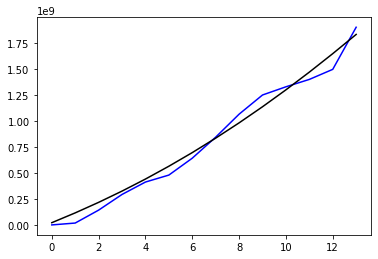

In [40]:
# plot filtering means and observation
plt.plot(time,df['Monthly active users'], color='blue')
plt.plot(time, filtering_means, color = "black")

As we can see, the observation follow logicaly the particle filter approximation of the filtering mean, wich is an estimation of the latent state. 

9. Using the particles package, run forward filtering and backward sampling to obtain 1000 samples from the smoothing distribution p(x0, x1, . . . , x13|θ, y b 0, y1,. . . , y13). Approximate the smoothing means E[Xt|θ, y b 0, y1, . . . , y13], for t = 0, 1, . . . , 13, and compare them to your approximation of the filtering means. Comment on your findings.

In [41]:
X,Y = bass.simulate(T+1)

# re-run particle filter and store its history
fk = ssm.Bootstrap(ssm = bass, data = Y) # create FeynmanKac object for the bootstrap particle filter
pf = particles.SMC(fk = fk, N = 1000, resampling = 'multinomial', ESSrmin = 1, collect = [Moments()], 
                   store_history = True)
pf.run() # actual computation is done

In [42]:
# forward filtering and backward smoothing
M = 20
Z = pf.hist.backward_sampling(M = M)
Z = np.array(Z)

In [43]:
# approximate the smoothing means
smoothing_means = np.mean(Z, axis = 1)

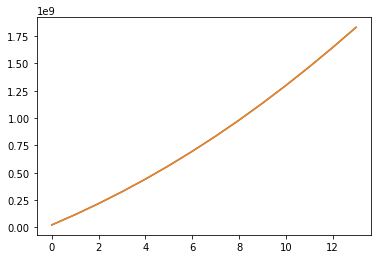

In [44]:
# compare the filtering and smoothing means
plt.plot(time, filtering_means)
plt.plot(time, smoothing_means)
plt.show()